In [48]:
import operator
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np

import figures
from cohort_model import (
    get_mean_and_std,
    population_survivorship_difference, 
    run_simulation,
    HYP_WILD_TYPE, 
    MUTANT_CAP,
    MUTANT_WILD
)
from fitness import get_fitness_data
from parameter_estimation import mean_survivorship

# Parameter estimation for case study 1 (*Frontinella pyramitela*)

## Estimating $\alpha$ and $\kappa$

**Note:** The $\alpha$ and $\kappa$ values used in figures 1 and 2 were obtained during an earlier least squares fitting. In restructuring the code for publication we have also improved the fitting procedure and obtained new and better values for $\alpha$ and $\kappa$. However, these are not used in the figure in order to produce results matching the ones in the published paper (which could not be updated by the time we obtained the better fit).

In [31]:
# Simulation parameters
individual_count = 1000 # Also used in figures 1, 2
repetition_count = 100  # Also used in figure 1
t_m_captivity = 201          # Also used in figure 1
t_m_wt = 100             # Also used in figure 1

cohort = np.ones(individual_count)

In [22]:
captivity_x = np.genfromtxt('data/austad_1989/captivity_x.txt')
captivity_x = np.genfromtxt('data/austad_1989/captivity_y.txt')

xdata = np.round(captivity_x).astype('int64') # In order to use for indexing
ydata = captivity_y * individual_count

In [9]:
%%time
data_count = len(xdata)

fit = []
for alpha in np.arange(0.0001, 0.0003, 0.00001): 
    for kappa in np.arange(0.02, 0.04, 0.0001): 
        hazard_rate_parameters = dict(alpha=alpha, kappa=kappa)
        population_survivorship = run_simulation(
            repetition_count, 
            cohort, 
            hazard_rate_parameters, 
            t_m_captivity, 
            population=MUTANT_CAP
        )
        mean = np.mean(population_survivorship, axis=0)[xdata]
        squares = [(mean[index] - ydata[index])**2 for index in range(data_count)] 
        fit.append((alpha, kappa, sum(squares)))

CPU times: user 5h 22min 6s, sys: 5h 23min 57s, total: 10h 46min 3s
Wall time: 11h 48min 21s


In [10]:
best_fits = sorted(fit, key=operator.itemgetter(2))
print(*best_fits[0:10], sep="\n")

(0.00017999999999999998, 0.03439999999999992, 1025.9572000000035)
(0.00017, 0.03489999999999991, 1052.283500000001)
(0.00015999999999999999, 0.03549999999999991, 1077.2380999999991)
(0.00019, 0.03419999999999991, 1079.1534000000008)
(0.00015999999999999999, 0.035399999999999904, 1084.1393999999975)
(0.00019, 0.033899999999999916, 1097.285300000001)
(0.00017999999999999998, 0.03449999999999991, 1097.6012999999969)
(0.00019, 0.03399999999999992, 1097.812399999998)
(0.00017, 0.03509999999999991, 1102.5906000000023)
(0.00017, 0.034999999999999906, 1109.3250999999993)


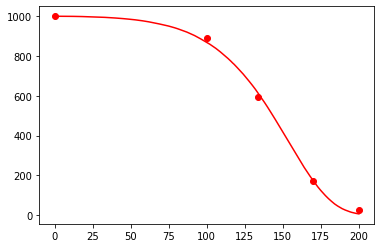

In [23]:
# Inspect the best fit
plt.plot(np.arange(t_m_captivity), mean_survivorship(np.arange(t_m_captivity), 0.00018, 0.0344, t_m_captivity, individual_count, repetition_count), 'r-')
plt.plot(xdata, ydata, 'ro')

### Estimating $\epsilon$ and $h_{wt}(t)$

In [42]:
x_wild = np.genfromtxt('data/austad_1989/wild_x.txt')
y_wild = np.genfromtxt('data/austad_1989/wild_y.txt')

xdata_w = np.round(x_wild).astype('int64') # In order to use for indexing
ydata_w = y_wild * individual_count

xdata_w = xdata_w[:-2] # In order not to fit to the last two data points
ydata_w = ydata_w[:-2] # In order not to fit to the last two data points

In [46]:
%%time
n = len(xdata_w)

fit = []
for prod_wt in np.arange(0.0378, 0.0382, 0.000025):  # prod_wt = (1 - epsilon) * h_wt
    hazard_rate_parameters = dict(alpha=None, kappa=None, hazard_rate_wild_type=prod_wt) # TODO: Refactor get_hazard_rate to not need alpha and kappa
    population_survivorship = run_simulation(
        repetition_count, 
        cohort, 
        hazard_rate_parameters, 
        101,  # TODO: t_m, cannot index with length 100 
        population=HYP_WILD_TYPE
    )
    mean = np.mean(population_survivorship, axis=0)[xdata_w]
    squares = [(mean[i] - ydata_w[i])**2 for i in range(n)] # Not fitting to last two data points in xdata_w,ydata_w
    fit.append((prod_wt, sum(squares)))

In [49]:
best_fits = sorted(fit, key=operator.itemgetter(1))
print(*best_fits[0:10], sep="\n")

(0.037949999999999984, 961.1146000000003)
(0.037924999999999986, 1009.9925000000006)
(0.037849999999999995, 1095.5961000000002)
(0.03789999999999999, 1121.5972999999976)
(0.03807499999999997, 1137.6909999999962)
(0.03817499999999996, 1145.7741999999948)
(0.03787499999999999, 1154.5780999999974)
(0.03814999999999996, 1171.3541999999995)
(0.037825, 1172.4280999999967)
(0.03799999999999998, 1175.9946)


In [55]:
prod_wt = best_fits[0][0]
for epsilon in np.arange(0.01, 0.05, 0.01):
    h_wt = prod_wt / (1 - epsilon)
    print(f'epsilon = {epsilon}, h_wt = {h_wt}')

epsilon = 0.01, h_wt = 0.038333333333333316
epsilon = 0.02, h_wt = 0.03872448979591835
epsilon = 0.03, h_wt = 0.03912371134020617
epsilon = 0.04, h_wt = 0.03953124999999998
